# Q-Learning:

* A model-free, value-based, off-policy algorithm that will find the best series of actions based on the agent's current state.
* Q = Quality
* **Model-based** algorithms use transition adn reward functions to estimate the optimal policy and create the model. Model-free algorithsm learn the consequences of their actions through the experience without transition and reward functions.
* **Value-based** method trains the value function to learn which state is more valuable and take action. 
* **Policy-based** methods train the policy directly to learn which action to take in a given state. 
* **Off-policy** algorithms evaluate and update a policy that differs from the policy used to take an action. 
* **On-policy** algorithms evaluate and improves the same policy used to take an action.

The Q-table is an agent maintined set of states and actions.

The Q-function uses the bellman equation and takes states and actions as input. 

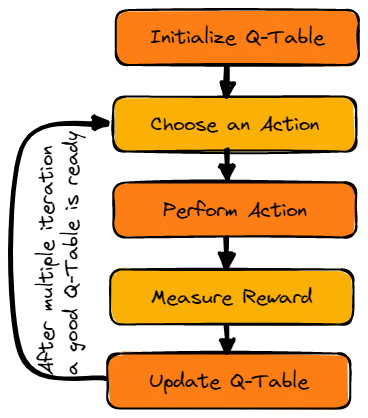

In [1]:

import numpy as np
import gymnasium as gym  # Updated import
import random
import imageio
from tqdm import trange  # Changed from tqdm.notebook

In [2]:
# Create environment
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample())

Observation Space Discrete(16)
Sample observation 2


In [3]:
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

Action Space Shape 4
Action Space Sample 1


Create and Initialize the Q-Table

In [4]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [5]:
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

Qtable_frozenlake = initialize_q_table(state_space, action_space)
Qtable_frozenlake

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [6]:
Qtable_frozenlake[0]

array([0., 0., 0., 0.])

# Using an Epsilon-greedy policy

Exploitation = 1 - epsilon
Exploration = epsilon

Generate a random number from 0 and 1. If > epsilon do exploitation else do exploration (Random Action)

In [7]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    random_int = random.uniform(0, 1)
    if random_int > epsilon:
        action = np.argmax(Qtable[state])
    else:
        action = env.action_space.sample()
    return action

# Defining greedy policy

Since Q-Learning is an off-policy algorithm (policy of taking action and updating function are different), define the greedy policy which will be the updating policy

In [8]:
def greedy_policy(Qtable, state):
    action = np.argmax(Qtable[state])
    return action

In [9]:
# Training parameters
n_training_episodes = 10000
learning_rate = 0.7        

# Evaluation parameters
n_eval_episodes = 100      

# Environment parameters
env_id = "FrozenLake-v1"   
max_steps = 99             
gamma = 0.95               
eval_seed = []             

# Exploration parameters
max_epsilon = 1.0           
min_epsilon = 0.05           
decay_rate = 0.0005              

# Model Training

1. Create a loop for training episodes.
2. We will first reduce epsilon. As we need less and less exploration and more exploitation with every episode. 
3. Reset the environment.
4. Create a nested loop for the maximum steps.
5. Choose the action using the epsilon greedy policy. 
6. Take action (At) and observe the expected reward(Rt+1) and state(St+1).
7. Take the action (a) and observe the outcome state(s') and reward (r).
8. Update the Q-function using the formula. 
9. If done= True, finish the episode and break the loop.
10. Finally, change the current state to a new state. 
11. After completing all of the training episodes, the function will return the updated Q-Table

In [10]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in trange(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        
        # Reset the environment - handle new gymnasium API
        result = env.reset()
        if isinstance(result, tuple):
            state, info = result
        else:
            state = result
        
        step = 0
        done = False

        # Training loop
        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            
            # Step in environment - handle new API
            step_result = env.step(action)
            if len(step_result) == 5:  # New API returns 5 values
                new_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:  # Old API returns 4 values
                new_state, reward, done, info = step_result

            # Q-learning update
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )

            # If done, finish the episode
            if done:
                break
            
            # Update state
            state = new_state
    
    return Qtable

In [11]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    """Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward."""
    episode_rewards = []
    for episode in range(n_eval_episodes):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            result = env.reset()
            if isinstance(result, tuple):
                state, info = result
            else:
                state = result
        
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action = greedy_policy(Q, state)
            step_result = env.step(action)
            
            if len(step_result) == 5:
                new_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                new_state, reward, done, info = step_result
            
            total_rewards_ep += reward
            
            if done:
                break
            state = new_state
        
        episode_rewards.append(total_rewards_ep)
    
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    
    return mean_reward, std_reward

In [12]:
print("Training started...")
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)
print("Training completed!")

# Evaluate the trained agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close the environment
env.close()

Training started...


100%|██████████| 10000/10000 [00:00<00:00, 21519.76it/s]

Training completed!
Mean reward: 1.00 +/- 0.00


In [13]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378092, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [15]:
Qtable_frozenlake[0]

array([0.73509189, 0.77378094, 0.77378094, 0.73509189])

c:\Users\Hiowa\AppData\Local\Programs\Python\Python313\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Video saved to replay.gif


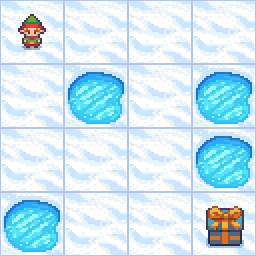

Video displayed above (if running in Jupyter-compatible environment)


In [14]:
def record_video(env, Qtable, out_directory, fps=1):
    """Record a video of the trained agent playing the game."""
    images = []
    done = False
    
    # Reset environment with seed - handle new API
    result = env.reset(seed=random.randint(0, 500))
    if isinstance(result, tuple):
        state, info = result
    else:
        state = result
    
    # Render first frame
    img = env.render()
    if img is not None:
        images.append(img)
    
    while not done:
        # Take the action with maximum expected future reward
        action = np.argmax(Qtable[state][:])
        
        # Step in environment - handle new API
        step_result = env.step(action)
        if len(step_result) == 5:
            state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        else:
            state, reward, done, info = step_result
        
        # Render frame
        img = env.render()
        if img is not None:
            images.append(img)
    
    # Save as GIF
    if images:
        imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)
        print(f"Video saved to {out_directory}")
    else:
        print("No frames captured - check if environment supports rendering")

# Create environment with render mode for video recording
env_video = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array")

# Record video
video_path = "replay.gif"  # Changed from /content/ path
video_fps = 1
record_video(env_video, Qtable_frozenlake, video_path, video_fps)

# Close the video environment
env_video.close()

# Display the GIF (VS Code compatible)
try:
    from IPython.display import Image, display
    display(Image('./replay.gif'))
    print("Video displayed above (if running in Jupyter-compatible environment)")
except ImportError:
    print("IPython not available. You can view the replay.gif file directly in your file explorer.")
    print("The GIF has been saved to your current working directory.")

# Close the main environment
env.close()